In [480]:
import pandas as pd
import numpy as np
import statsmodels
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima_model import ARIMA
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

from tqdm import tqdm

import quandl

import warnings
warnings.filterwarnings('ignore')

seed = 10031998

In [217]:
np.random.seed(seed)

In [128]:
def create_lagged_dataset(dataset, lag=1):
    df = pd.DataFrame(dataset)
    for i in range(lag):
        new_feature = df.T.tail(1).T.shift(-1)
        df = pd.concat((df, new_feature), axis=1)
    dataX = df.values[:len(dataset) - lag,:-1]
    dataY = df.values[:len(dataset) - lag,-1]
    return dataX, dataY

In [91]:
# source: https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [258]:
# ts_df = quandl.get("FRBP/ROUTPUT_MOSTRECENT", authtoken="MHASo5sqBFCvT5s55CxJ")
ts_df = quandl.get("FRED/DFF", authtoken="MHASo5sqBFCvT5s55CxJ")

In [259]:
ts_df.tail()

,Value
Date,
2019-05-13,2.38
2019-05-14,2.38
2019-05-15,2.40
2019-05-16,2.39
2019-05-17,2.39


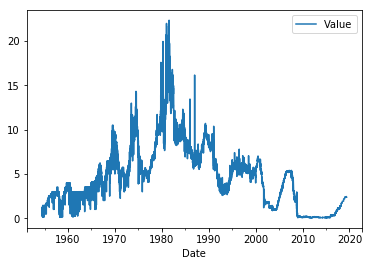

In [260]:
ts_df.plot();

In [349]:
# TOO SLOW !!!


# # for RandomForest
# def validate_gamma(lags, n_splits, ts, gamma_test_part = 6, gammas=[0.3, 0.9, 1]):
#     ts_gamma_train = ts.values[: (gamma_test_part - 1) * int(ts.shape[0] // gamma_test_part)]
#     ts_gamma_test = ts.values[(gamma_test_part - 1) * int(ts.shape[0] // gamma_test_part):]
    
#     res_mape = {}
#     tscv = TimeSeriesSplit(n_splits=n_splits)
#     gammas_best = []
#     i = -1
#     for gamma in gammas:
#         i += 1
#         lowest_mape = 10**10
#         gammas_best.append(-1)
#         for lag in lags:
#             mapes = []
#             for train_index, test_index in tscv.split(ts_gamma_train):
#                 ts_train, ts_test = ts_gamma_train[train_index], ts_gamma_train[test_index]

#                 # train test
#                 X_train, y_train = create_lagged_dataset(ts_train, lag=lag)
#                 X_test, y_test = create_lagged_dataset(ts_test, lag=lag)
#                 model = RandomForestRegressor(random_state=seed)
#                 model.fit(X_train,y_train)
#                 y_hat = model.predict(X_test)

#                 mapes.append(mean_absolute_percentage_error(y_test, y_hat))

            
#             powers = np.arange(len(mapes))[::-1]
#             gammas = np.ones(len(mapes)) * gamma
#             print(np.mean(np.power(gammas, powers) * mapes))
#             res_mape[str(gamma) + "_" + str(lag)] = np.mean(np.power(gammas, powers) * mapes)
#             if np.mean(np.power(gammas, powers) * mapes) < lowest_mape:
#                 gammas_best[i] = lag
#                 lowest_mape = np.mean(np.power(gammas, powers) * mapes)
            
#     mapes_for_gammas = []
#     best_gamma = None
#     if len(np.unique(gammas_best)) == 1:
#         best_gamma = "same_results"
#     else:
#         for gamma_best in gammas_best:
            
#             X_train, y_train = create_lagged_dataset(ts_gamma_train, lag=gamma_best)
#             X_test, y_test = create_lagged_dataset(ts_gamma_test, lag=gamma_best)
#             model = RandomForestRegressor()
#             model.fit(X_train, y_train)
            
#             y_hat = model.predict(X_test)
#             mapes_for_gammas.append(mean_absolute_percentage_error(y_test, y_hat))
        
#         best_gamma = gammas[np.argmin(mapes_for_gammas)]
            
#     return res_mape , gammas_best , best_gamma
            
    
            

In [481]:
# for RandomForest

def validate_gamma(lags, n_splits, ts, gamma_test_part = 7, gammas=[0.3, 0.5, 0.9, 1]):
    ts_gamma_train = ts.values[: (gamma_test_part - 1) * int(ts.shape[0] // gamma_test_part)]
    ts_gamma_test = ts.values[(gamma_test_part - 1) * int(ts.shape[0] // gamma_test_part):]
    
    res_mape = {}
    tscv = TimeSeriesSplit(n_splits=n_splits)
    gammas_best = []
    i = -1

    for lag in lags:
        mapes = []
        for train_index, test_index in tscv.split(ts_gamma_train):
            ts_train, ts_test = ts_gamma_train[train_index], ts_gamma_train[test_index]

            # train test
            X_train, y_train = create_lagged_dataset(ts_train, lag=lag)
            X_test, y_test = create_lagged_dataset(ts_test, lag=lag)
            model = RandomForestRegressor(random_state=seed)
            model.fit(X_train,y_train)
            y_hat = model.predict(X_test)

            mapes.append(mean_absolute_percentage_error(y_test, y_hat))


        for gamma in gammas:
            powers = np.arange(len(mapes))[::-1]
            gammas_pow = np.ones(len(mapes)) * gamma
            res_mape[str(gamma) + "_" + str(lag)] = np.mean(np.power(gammas_pow, powers) * mapes)
            
#     print(res_mape)
    i = -1
    for gamma in gammas:
        i += 1
        lowest_mape = 10**10
        gammas_best.append(-1)
        for lag in lags:
            if res_mape[str(gamma) + "_" + str(lag)] < lowest_mape:
                lowest_mape = res_mape[str(gamma) + "_" + str(lag)]
                gammas_best[i] = lag
            
            
    mapes_for_gammas = []
    best_gamma = None
    if len(np.unique(gammas_best)) == 1:
        best_gamma = "same_results_all_models"
    else:
        for gamma_best in gammas_best:
            X_train, y_train = create_lagged_dataset(ts_gamma_train, lag=gamma_best)
            X_test, y_test = create_lagged_dataset(ts_gamma_test, lag=gamma_best)
            model = RandomForestRegressor()
            model.fit(X_train, y_train)
            
            y_hat = model.predict(X_test)
            mapes_for_gammas.append(mean_absolute_percentage_error(y_test, y_hat))
        
        best_gamma = gammas[np.argmin(mapes_for_gammas)]
    
    if best_gamma != "same_results_all_models":
        if gammas_best[np.argmin(mapes_for_gammas)] == gammas_best[-1]:
            best_gamma = "gamma_1_is_ok"
    return res_mape , gammas_best , best_gamma
            
    
            

In [465]:
validate_gamma([1,2,3], 5, ts_df)

({'0.3_1': 6.871597961601185,
  '0.3_2': 3.9077928392117327,
  '0.3_3': 3.4847643402626973,
  '0.9_1': 12.15140925977995,
  '0.9_2': 9.404353831233056,
  '0.9_3': 9.121029712470856,
  '1_1': 14.407775670678138,
  '1_2': 11.765602622094434,
  '1_3': 11.557189843234141},
 [3, 3, 3],
 'same_results_all_models')

In [451]:
# M4 competition
df = pd.read_csv("Monthly-train.csv")

In [452]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V2786,V2787,V2788,V2789,V2790,V2791,V2792,V2793,V2794,V2795
0,M1,8000.0,8350.0,8570.0,7700.0,7080.0,6520.0,6070.0,6650.0,6830.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M2,2440.0,2490.0,2710.0,2290.0,1960.0,1990.0,1960.0,2530.0,2640.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,M3,2670.0,2590.0,2784.0,2816.0,2888.0,2906.0,2839.0,2860.0,2798.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,M4,7264.0,7215.0,7022.0,7040.0,6966.0,6984.0,7025.0,7082.0,6956.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,M5,4210.0,4290.0,4250.0,4320.0,4320.0,4330.0,4320.0,4260.0,4220.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


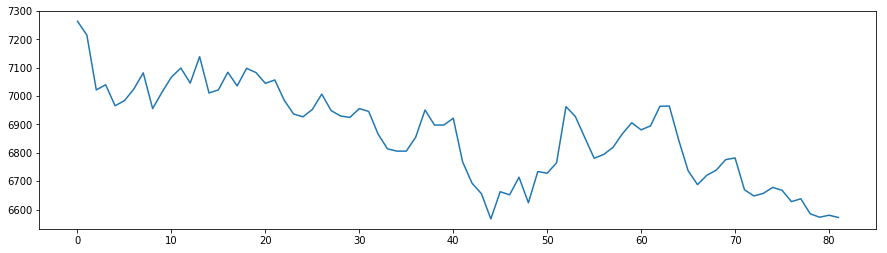

In [508]:
plt.figure(figsize=(15,4))
x = df[3:4].values[0][1:]
x = np.array(x, dtype=float)
x = x[~np.isnan(x)]
plt.plot(x);

In [495]:
np.arange(1, 4 * int(np.log(80)))

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [505]:
validate_gamma(np.arange(1, x.shape[0] // 10, 5), 5, pd.DataFrame(x))

({'0.3_1': 4.380766824741709,
  '0.3_11': 2.999322264129979,
  '0.3_16': 2.739794992357799,
  '0.3_21': 2.9305856874300527,
  '0.3_26': 3.156379102164771,
  '0.3_31': 2.662089495179854,
  '0.3_36': 2.982148257915736,
  '0.3_41': 3.2742796827424328,
  '0.3_6': 3.931893684079393,
  '0.5_1': 5.808757292500767,
  '0.5_11': 4.445307530880145,
  '0.5_16': 3.8707160092386728,
  '0.5_21': 4.047928117304226,
  '0.5_26': 4.414368327681345,
  '0.5_31': 3.7627452548427156,
  '0.5_36': 4.154339969538625,
  '0.5_41': 4.542074837343252,
  '0.5_6': 5.556588810877784,
  '0.9_1': 11.23072800813245,
  '0.9_11': 10.444056674110229,
  '0.9_16': 8.554135349770679,
  '0.9_21': 8.488039229803734,
  '0.9_26': 9.453920440616546,
  '0.9_31': 8.125267556453853,
  '0.9_36': 9.003938905464173,
  '0.9_41': 10.062306046610782,
  '0.9_6': 12.520030829700604,
  '1_1': 13.373468856634641,
  '1_11': 12.890857324230648,
  '1_16': 10.485065767839256,
  '1_21': 10.280121243720583,
  '1_26': 11.495049957080097,
  '1_31': 9.8

In [513]:
hist = []
for i in tqdm(range(df.shape[0] - 2)):
    x = df[i:i+1].values[0][1:]
    x = np.array(x, dtype=float)
    x = x[~np.isnan(x)] 
    _, _, best_gamma = validate_gamma(np.arange(1, x.shape[0] // 10, 5), 5, pd.DataFrame(x))
    hist.append(best_gamma)


  0%|                                                                             | 8/47998 [00:47<78:53:57,  5.92s/it]

KeyboardInterrupt: 

In [512]:
hist

['same_results_all_models',
 0.5,
 'same_results_all_models',
 'same_results_all_models',
 'same_results_all_models']